In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
np.random.seed(0)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-27,122.800003,122.800003,119.820000,120.332497,88.088272,30646000.0
2004-08-30,121.237503,123.750000,120.625000,123.345001,90.293549,24465208.0
2004-08-31,123.312500,123.750000,122.000000,123.512497,90.416122,21194656.0
2004-09-01,123.750000,124.375000,122.949997,123.487503,90.397820,19935544.0
2004-09-02,123.737503,125.574997,123.250000,124.207497,90.924896,21356352.0


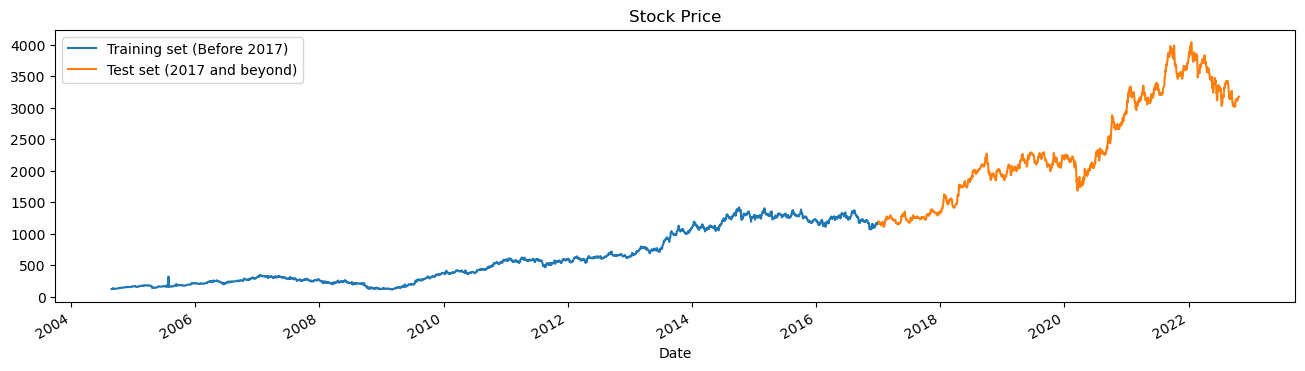

In [2]:
dataset = pd.read_csv('TCS.csv', index_col='Date', parse_dates=['Date'])
display(dataset.head())

# We are going to predict the high attribute of stocks. Let's visualize it
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Stock Price')
plt.show()

In [3]:
dataset.isna().sum()

Open         8
High         8
Low          8
Close        8
Adj Close    8
Volume       8
dtype: int64

In [4]:
rowswithnull =dataset[dataset.isnull().any(axis=1)]
rowswithnull.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-10-13,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-06,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-03,NaN,NaN,NaN,NaN,NaN,NaN
2012-09-08,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
rowswithoutnulls = dataset[dataset.notnull().all(axis=1)]
rowswithoutnulls.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-27,122.800003,122.800003,119.820000,120.332497,88.088272,30646000.0
2004-08-30,121.237503,123.750000,120.625000,123.345001,90.293549,24465208.0
2004-08-31,123.312500,123.750000,122.000000,123.512497,90.416122,21194656.0
2004-09-01,123.750000,124.375000,122.949997,123.487503,90.397820,19935544.0
2004-09-02,123.737503,125.574997,123.250000,124.207497,90.924896,21356352.0


In [6]:
dataset = rowswithoutnulls
rowswithoutnulls.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
train_set = dataset[:'2016']["High"].values
test_set = dataset['2017':]["High"].values
print(train_set.shape, test_set.shape)

(3049,) (1437,)


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_set = scaler.fit_transform(np.reshape(train_set, (-1, 1)))
test_set = scaler.fit_transform(np.reshape(test_set, (-1, 1)))

sequence_length = 60
X_train, Y_train = list(), list()
for i in range(train_set.shape[0] - sequence_length):
    X_train.append(train_set[i:i + sequence_length, 0])
    Y_train.append(train_set[i + sequence_length, 0])
X_train, Y_train = np.asarray(X_train), np.asarray(Y_train)

X_test, Y_test = list(), list()
for i in range(test_set.shape[0] - sequence_length):
    X_test.append(test_set[i:i + sequence_length, 0])
    Y_test.append(test_set[i + sequence_length, 0])
X_test, Y_test = np.asarray(X_test), np.asarray(Y_test)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(2989, 60) (1377, 60)
(2989,) (1377,)


In [9]:
model = Sequential([
        LSTM(60, input_shape = (sequence_length,1), activation = 'tanh'),
        Dense(units = 64, activation="relu"),
        Dropout(0.1),
        Dense(units = 1, activation = 'relu'),
    ]) 

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                14880     
                                                                 
 dense (Dense)               (None, 64)                3904      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,849
Trainable params: 18,849
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train, Y_train,validation_data=(X_test,Y_test), epochs= 20, batch_size = 4)
loss_history = history.history['loss']

Epoch 1/20
748/748 [==============================] - 43s 48ms/step - loss: 0.0050 - val_loss: 8.6918e-04
Epoch 2/20
748/748 [==============================] - 35s 47ms/step - loss: 0.0017 - val_loss: 6.3451e-04
Epoch 3/20
748/748 [==============================] - 36s 48ms/step - loss: 0.0014 - val_loss: 4.2246e-04
Epoch 4/20
748/748 [==============================] - 36s 48ms/step - loss: 0.0013 - val_loss: 2.9514e-04
Epoch 5/20
748/748 [==============================] - 36s 48ms/step - loss: 0.0013 - val_loss: 2.6975e-04
Epoch 6/20
748/748 [==============================] - 35s 47ms/step - loss: 0.0011 - val_loss: 2.5796e-04
Epoch 7/20
748/748 [==============================] - 37s 49ms/step - loss: 9.6697e-04 - val_loss: 2.7652e-04
Epoch 8/20
748/748 [==============================] - 38s 50ms/step - loss: 8.8772e-04 - val_loss: 2.2753e-04
Epoch 9/20
748/748 [==============================] - 35s 47ms/step - loss: 9.9578e-04 - val_loss: 3.8803e-04
Epoch 10/20
748/748 [=============

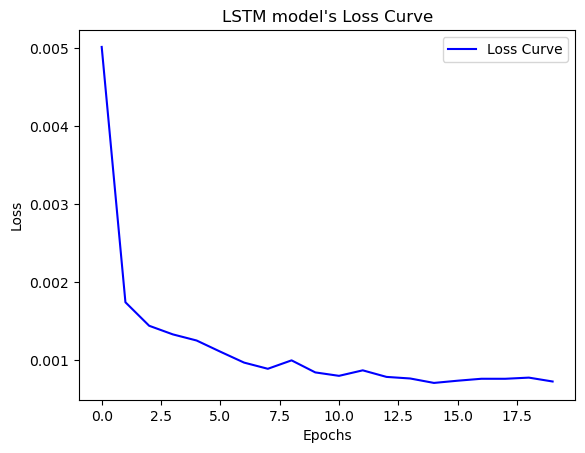

In [11]:
plt.plot(loss_history, color = 'blue', label = 'Loss Curve')
plt.title('LSTM model\'s Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

44/44 [==============================] - 3s 21ms/step


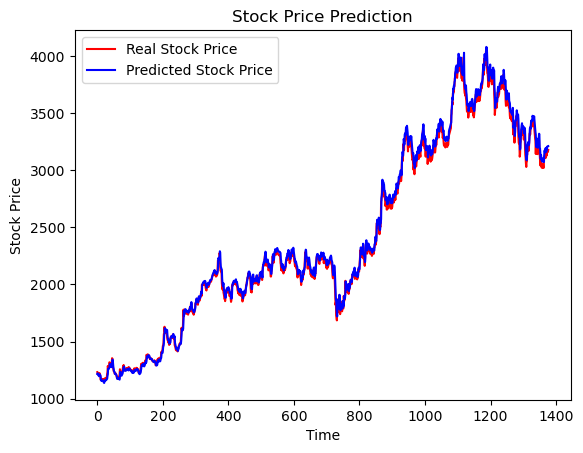

In [12]:
test_predict = model.predict(X_test)
orgpredict = scaler.inverse_transform(test_predict)
y_test_org =scaler.inverse_transform(Y_test.reshape(-1, 1))
plt.plot(y_test_org, color='red',label='Real Stock Price')
plt.plot(orgpredict, color='blue',label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

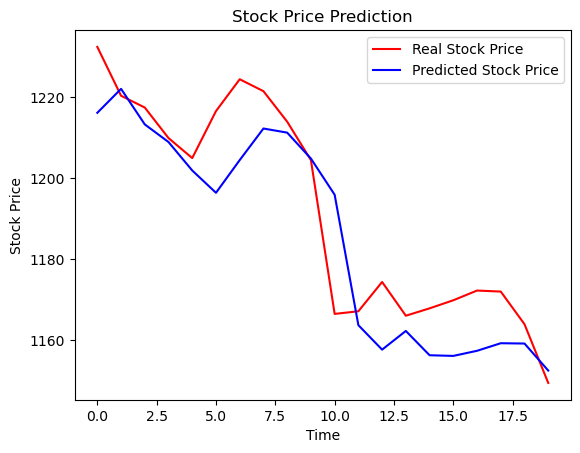

In [13]:
plt.plot(y_test_org[:20], color='red',label='Real Stock Price')
plt.plot(orgpredict[:20], color='blue',label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [14]:
loss = (np.sum(np.square(Y_test - np.squeeze(test_predict)))/len(test_predict))
print("Loss: ",loss)

Loss:  0.0002605871532753965


In [15]:
r_squared = r2_score(Y_test[:20], np.squeeze(test_predict[:20]))
print("R-squared:", r_squared)

R-squared: 0.7692758830836797


In [16]:
y_pred = orgpredict[:20]
y_true = y_test_org[:20]
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

mae = mean_absolute_error(y_true, y_pred)
mdape = median_absolute_percentage_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Median Absolute Percentage Error (MdAPE):", mdape)
print("Root mean square error (RMSE):", rmse)

Mean Absolute Error (MAE): 9.653503462890626
Median Absolute Percentage Error (MdAPE): 0.5834864581713715
Root mean square error (RMSE): 12.479438081256138
